In [112]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import seaborn as sns

## 1. Load data

In [29]:
# shapefile
sf = gpd.read_file('../data/landing/SA2_2021_AUST_GDA2020.shp')
sf = sf[sf['STE_NAME21'] == 'Victoria']
sf = sf[['SA2_NAME21', 'AREASQKM21', 'geometry']]
sf = sf.iloc[:-2, :]
sf.columns = ['sa2', 'area', 'geometry']
sf['sa2'] = sf['sa2'].apply(lambda x: x.lower())

In [30]:
prop_feature = pd.read_csv('../data/curated/prop_feature.csv')

In [31]:
prop_feature = shuffle(prop_feature, random_state=1234)
prop_feature

,id,sa2,type,price,bond,bed,bath,parking,is_furnished,dist_CBD,dist_public_transport,dist_hospital,dist_police_station,dist_supermarket,dist_market,dist_shopping_center,dist_school
5818,5836,torquay,House,500.0,2172.0,3.0,1.0,0.0,0,103178,2019,12497,1845,1317,2211,1598,1664
6199,6267,dandenong north,House,480.0,2087.0,3.0,2.0,2.0,0,33392,3214,1422,3615,1409,2136,3261,316
1746,1604,blackburn,House,750.0,2738.0,3.0,3.0,2.0,0,21635,666,2666,1806,1451,3823,1290,1467
2237,2297,alphington - fairfield,House,699.0,3037.0,3.0,2.0,1.0,0,9505,2912,3485,1877,2026,2809,2153,940
5016,4933,southbank - east,Apartment / Unit / Flat,550.0,2389.0,1.0,1.0,0.0,1,2089,640,1645,302,158,962,569,1030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,651,mentone,House,1000.0,4345.0,5.0,3.0,3.0,0,29622,1220,3744,3434,861,1511,2332,1282
7540,7625,richmond (south) - cremorne,Apartment / Unit / Flat,390.0,1695.0,1.0,1.0,0.0,0,3404,547,777,994,1942,1158,2336,388
7221,7282,caroline springs,House,400.0,1738.0,2.0,2.0,1.0,0,28496,2865,7679,1602,1527,1678,1492,478
1318,1342,melbourne cbd - north,Apartment / Unit / Flat,800.0,3476.0,2.0,2.0,1.0,1,1450,1127,1801,1934,157,1754,1134,1025


In [32]:
sa2_encoder = LabelEncoder()
sa2_encoder.fit(['other state'] + sf['sa2'].to_list())
prop_feature['sa2'] = sa2_encoder.transform(prop_feature['sa2'])

type_encoder = LabelEncoder()
type_encoder.fit(prop_feature['type'].unique().tolist())
prop_feature['type'] = type_encoder.transform(prop_feature['type'])

In [33]:
feature_data = prop_feature[['sa2', 'type', 'bond', 'bed', 'bath', 'parking',
                                        'is_furnished', 'dist_CBD', 'dist_public_transport', 'dist_hospital',
                                        'dist_police_station', 'dist_supermarket', 'dist_market',
                                        'dist_shopping_center', 'dist_school']]
price_data = prop_feature['price']

In [34]:
x, x_test, y,  y_test = train_test_split(feature_data, price_data, train_size=0.9, shuffle=False)

## 2. Model

In [115]:
def percent_diff(predict, true, limit=0.05, output='p'):
    """This function calulate the how close the result of the prediction is to the true value
        based on the percent different of the two

    Args:
        predict (array): array of the predicted value
        true (array): array of the true value to be compared to
        percent_output (bool, optional): return the percent different array if True. Defaults to False.
        limit (float, optional): If percent_output is False, percent different array is compared to be less 
                                           than the limit and return the percent of True . Defaults to 0.05.

    Returns:
        array or float: read Args for more info
    """    
    if len(predict) != len(true):
        print('Not same length')
        return False
    # 
    predict = np.array(predict)
    true = np.array(true)
    percent = np.abs(predict -  true) / true
    
    if output == 'l':
        return percent
    if output == 'p':
        return np.sum(percent < limit) / len(true)
    if output == 'a':
        return np.average(percent)
    
percent_diff([100, 101, 99], [100, 100, 100], output='a') * 100

0.6666666666666667

#### Random Forest

In [128]:
N_TREE = [10, 100, 200, 300, 400, 500]
MAX_DEPTH = [2, 3, 4, 5, 6, 7, 8, 9]

In [129]:
rf_models = {n_tree: [] for n_tree in N_TREE}
for n_tree in N_TREE:
    for depth in MAX_DEPTH:
        print(n_tree, depth)
        regr = RandomForestRegressor(n_estimators=n_tree ,max_depth=depth, max_features='log2', random_state=1234, n_jobs=-1)
        regr.fit(x, y)
        rf_models[n_tree].append(regr)

10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
200 2
200 3
200 4
200 5
200 6
200 7
200 8
200 9
300 2
300 3
300 4
300 5
300 6
300 7
300 8
300 9
400 2
400 3
400 4
400 5
400 6
400 7
400 8
400 9
500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9


In [130]:
rf_score = {score: {n_tree: [] for n_tree in N_TREE}
                 for score in ['mse', 'rs']}
for n_tree in N_TREE:
    for depth in MAX_DEPTH:
        model = rf_models[n_tree][depth - 2]
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        rs = r2_score(y_test, y_pred)
        rf_score['mse'][n_tree].append(mse)
        rf_score['rs'][n_tree].append(rs)

,10,100,200,300,400,500
0,70220.218031,64473.556350,62692.329679,61632.479348,61692.082940,61301.924411
1,56577.124755,50520.647792,50455.954800,49805.626583,49856.005652,49606.460218
2,47080.385426,41851.571184,41606.650286,41104.754533,40846.117257,40673.295794
3,35831.356841,33851.885756,33237.389142,34282.738122,34217.382936,34333.276920
4,29590.785338,31523.157451,30431.458054,30131.590903,29780.334623,29876.478697
5,26739.677017,26528.545735,26616.420398,26710.328220,26700.976266,26859.759921
6,26675.884971,24933.086230,24423.035847,23866.400271,23719.380495,23744.116596
7,27003.623160,22384.456066,21840.810468,22019.997850,21868.872569,21877.346432


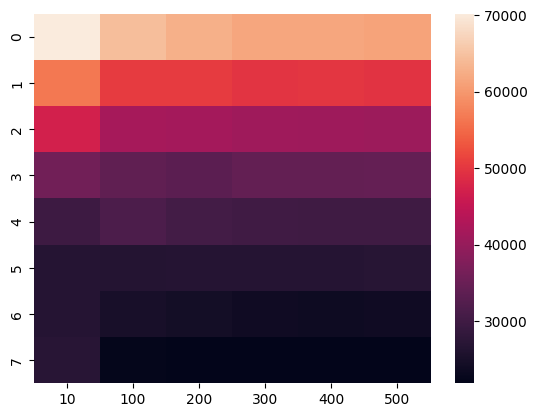

In [132]:
result = pd.DataFrame(rf_score['mse'])
sns.heatmap(result)
result

,10,100,200,300,400,500
0,0.354412,0.407245,0.423622,0.433366,0.432818,0.436405
1,0.479843,0.535525,0.536120,0.542099,0.541636,0.543930
2,0.567154,0.615227,0.617478,0.622093,0.624471,0.626059
3,0.670575,0.688774,0.694423,0.684813,0.685414,0.684348
4,0.727949,0.710184,0.720220,0.722977,0.726207,0.725323
5,0.754162,0.756103,0.755295,0.754432,0.754518,0.753058
6,0.754748,0.770771,0.775460,0.780578,0.781930,0.781702
7,0.751735,0.794203,0.799201,0.797553,0.798943,0.798865


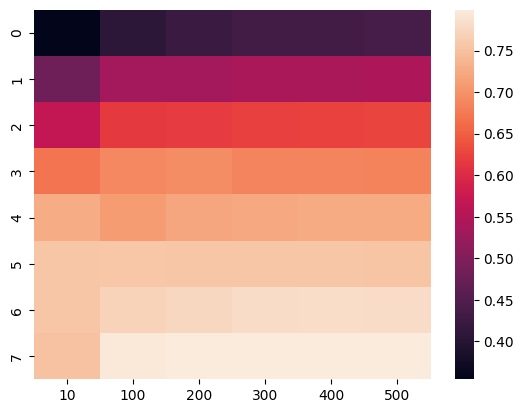

In [133]:
result = pd.DataFrame(rf_score['rs'])
sns.heatmap(result)
result

In [142]:
RFG = RandomForestRegressor(n_estimators=200 ,max_depth=9, max_features='log2', random_state=1234, n_jobs=-1)
RFG.fit(x, y)

RandomForestRegressor(max_depth=9, max_features='log2', n_estimators=200,
                      n_jobs=-1, random_state=1234)

(100.0, 2000.0)

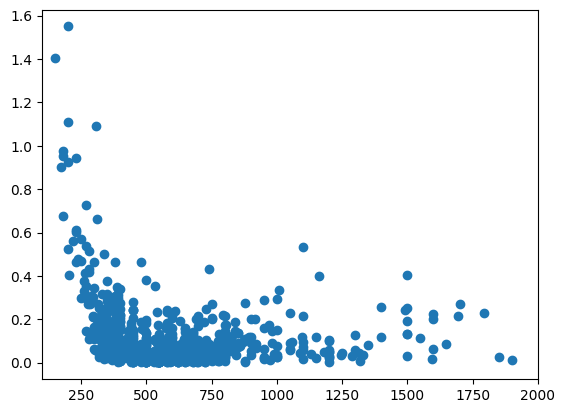

In [160]:
pcd_list = percent_diff(RFG.predict(x_test), y_test, output='l')
plt.scatter(y_test, pcd_list)
plt.xlim(100, 2000)
# plt.xticks(range(100, 2000, 100))

In [56]:
kmeans_models = []
for i in range(3, 40):
    # print(i)
    km = KMeans(n_clusters=i, random_state=0, n_init="auto")
    km.fit(x)
    kmeans_models.append(km)

[0.7496449103377928,
 0.8035608687099748,
 0.8212976647957557,
 0.8291378928599507]

In [39]:
X = sm.add_constant(x)
res = sm.OLS(y, x).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                              3336.
Date:                Thu, 05 Oct 2023   Prob (F-statistic):                        0.00
Time:                        21:06:55   Log-Likelihood:                         -56434.
No. Observations:                8082   AIC:                                  1.129e+05
Df Residuals:                    8067   BIC:                                  1.130e+05
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sa2                       0.2120      0.017     12.254      0.000       0.178       0.246
type                    -52.8771      6.880     -7.686      0.000     -66.363     -39.391
bond                      0.0192      0.001     27.060      0.000       0.018       0.021
bed                      89.4272      3.858     23.180      0.000      81.864      96.990
bath                    200.9372      5.338     37.641      0.000     190.473     211.402
parking                   8.6047      3.137      2.743      0.006       2.455      14.754
is_furnished            163.7511      8.332     19.653      0.000     147.418     180.085
dist_CBD                 -0.0008   4.09e-05    -19.284      0.000      -0.001      -0.001
dist_public_transport     0.0013      0.001      1.005      0.315      -0.001       0.004
dist_hospital             0.0033      0.000      6.628      0.000       0.002       0.004
dist_police_station      -0.0099      0.001     -8.592      0.000      -0.012      -0.008
dist_supermarket          0.0014      0.002      0.661      0.508      -0.003       0.006
dist_market              -0.0073      0.002     -3.608      0.000      -0.011      -0.003
dist_shopping_center      0.0014      0.001      2.412      0.016       0.000       0.003
dist_school               0.0011      0.002      0.514      0.607      -0.003       0.005
==============================================================================
Omnibus:                     3599.063   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1455103.099
Skew:                           0.823   Prob(JB):                         0.00
Kurtosis:                      68.714   Cond. No.                     2.70e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""